# **COVEN-X: A Suite of VAMPIRE-X Models With Different Thresholds**

We create COVEN (**C**ollection **O**f **V**AMPIRE models for **E**nhanced **N**otifications). Which is a suite of VAMPIRE-X Models, each with a different alert thresold derived from percentiles of the distrbution of the maximum 1.8 MeV Electron flux in the Outer Radiation Belt. This notebook will train these models, and test their performance. The created models are:

*   VAMPIRE-X60 (Threshold at the 60th Percentile ~$10^{5.86}$pfu)
*   VAMPIRE-X70 (Threshold at the 70th Percentile ~$10^{6.05}$pfu)
*   VAMPIRE-X80 (Threshold at the 80th Percentile ~$10^{6.26}$pfu)
*   VAMPIRE-X90 (Threshold at the 90th Percentile ~$10^{6.57}$pfu)
*   VAMPIRE-X95 (Threshold at the 95th Percentile ~$10^{6.78}$pfu)

In [77]:
#Install all the packages
!pip install numpy==1.26.0
!pip install matplotlib==3.8.0
!pip install scikit-learn==1.6.1
!pip install tqdm==4.66.1
!pip install joblib==1.3.2
!pip install pandas==2.1.1
!pip install wget
!pip install cblind

In [78]:
# Importing all the required packages
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from tqdm import tqdm
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from datetime import datetime, timedelta
import pandas as pd
import wget

import cblind as cb

# Importing Each Fold
Import each fold of the data, these are stored in a zenodo repositary and can be downloaded straight from there.

We use a chronological split to form 3 folds, we then take 2 folds as the training set and 1 as the test set, we then iterate through allowing us obtain errors on our metrics. This process is called k-fold analysis.

In [79]:
#### PUT THE FETCHING CODE HERE ####

fold1=pd.read_csv(wget.download('https://zenodo.org/records/18622762/files/Fold_1.csv'))
fold2=pd.read_csv(wget.download('https://zenodo.org/records/18622762/files/Fold_2.csv'))
fold3=pd.read_csv(wget.download('https://zenodo.org/records/18622762/files/Fold_3.csv'))



The following code block defines which inputs are used for each model and lead time

In [80]:
inputs=[
    [#X60
        #0-day lead time
             ['mean_roll_AL_1', 'mean_roll_AL_3', 'mean_roll_AL_4', 'median_roll_AL_5', 'max_roll_AL_6', 'mean_roll_AL_7'] ,
        #1-day lead time
             ['mean_roll_AL_3', 'mean_roll_AL_4', 'mean_roll_AL_7', 'mean_roll_AL_8', 'median_roll_AL_5'] ,
        #2-day lead time
             ['mean_roll_AL_3', 'mean_roll_AL_4', 'mean_roll_AL_7', 'mean_roll_AL_9', 'median_roll_AL_5', 'median_roll_AL_9'] ,
        #3-day lead time
             ['mean_roll_AL_6', 'mean_roll_AL_9', 'median_roll_AL_4', 'max_roll_AL_5', 'max_roll_AL_8'] ,
        #4-day lead time
             ['mean_roll_AL_6', 'mean_roll_AL_9', 'median_roll_AL_5', 'median_roll_AL_10', 'max_roll_AL_7'] ,
        #5-day lead time
             ['mean_roll_AL_6', 'mean_roll_AL_7', 'median_roll_AL_10', 'median_roll_AL_12', 'max_roll_AL_8'] ,
        #6-day lead time
             ['mean_roll_AL_7', 'mean_roll_AL_9', 'mean_roll_AL_13', 'median_roll_AL_8', 'median_roll_AL_11'] ],
    [#X70
        #0-day lead time
             ['mean_roll_AL_1', 'mean_roll_AL_3', 'max_roll_AL_6', 'mean_roll_AL_7'] ,
        #1-day lead time
             ['mean_roll_AL_2', 'mean_roll_AL_4', 'mean_roll_AL_5', 'mean_roll_AL_6', 'median_roll_AL_8', 'max_roll_AL_2'] ,
        #2-day lead time
             ['mean_roll_AL_3', 'mean_roll_AL_4', 'mean_roll_AL_7', 'median_roll_AL_3', 'median_roll_AL_8', 'max_roll_AL_9'] ,
        #3-day lead time
             ['mean_roll_AL_4', 'mean_roll_AL_5', 'mean_roll_AL_10', 'median_roll_AL_7'] ,
        #4-day lead time
             ['mean_roll_AL_5', 'median_roll_AL_8', 'median_roll_AL_9', 'median_roll_AL_11', 'max_roll_AL_7'] ,
        #5-day lead time
             ['mean_roll_AL_6', 'mean_roll_AL_7', 'median_roll_AL_10', 'max_roll_AL_8', 'max_roll_AL_12'] ,
        #6-day lead time
             ['mean_roll_AL_7', 'mean_roll_AL_10', 'mean_roll_AL_12', 'median_roll_AL_8', 'max_roll_AL_13'] ],
    [#X80
        #0-day lead time
             ['mean_roll_AL_1', 'mean_roll_AL_3', 'mean_roll_AL_4', 'median_roll_AL_5', 'mean_roll_AL_7'] ,
        #1-day lead time
             ['mean_roll_AL_2', 'mean_roll_AL_3', 'mean_roll_AL_5', 'mean_roll_AL_7', 'median_roll_AL_2', 'max_roll_AL_8'] ,
        #2-day lead time
             ['mean_roll_AL_3', 'mean_roll_AL_4', 'mean_roll_AL_7', 'max_roll_AL_9'] ,
        #3-day lead time
             ['mean_roll_AL_4', 'mean_roll_AL_5', 'mean_roll_AL_7', 'max_roll_AL_10'] ,
        #4-day lead time
             ['mean_roll_AL_6', 'median_roll_AL_5', 'median_roll_AL_7', 'median_roll_AL_10', 'max_roll_AL_8', 'max_roll_AL_11'] ,
        #5-day lead time
             ['mean_roll_AL_6', 'mean_roll_AL_8', 'max_roll_AL_10', 'max_roll_AL_12'] ,
        #6-day lead time
             ['mean_roll_AL_7', 'mean_roll_AL_10', 'mean_roll_AL_12', 'median_roll_AL_9'] ],
    [#X90
        #0-day lead time
             ['mean_roll_AL_1', 'mean_roll_AL_3', 'mean_roll_AL_4', 'median_roll_AL_5', 'mean_roll_AL_7'] ,
        #1-day lead time
             ['mean_roll_AL_2', 'mean_roll_AL_3', 'median_roll_AL_6'] ,
        #2-day lead time
             ['mean_roll_AL_3', 'median_roll_AL_6', 'median_roll_AL_8', 'max_roll_AL_5'] ,
        #3-day lead time
             ['mean_roll_AL_4', 'mean_roll_AL_7', 'max_roll_AL_4', 'max_roll_AL_6'] ,
        #4-day lead time
             ['median_roll_AL_5', 'median_roll_AL_7', 'max_roll_AL_5', 'max_roll_AL_11'] ,
        #5-day lead time
             ['mean_roll_AL_6', 'mean_roll_AL_8', 'median_roll_AL_10', 'max_roll_AL_6', 'max_roll_AL_10'] ,
        #6-day lead time
             ['mean_roll_AL_7', 'median_roll_AL_11', 'median_roll_AL_13', 'max_roll_AL_9'] ],
    [#X95
        #0-day lead time
             ['mean_roll_AL_1', 'mean_roll_AL_3', 'median_roll_AL_5', 'mean_roll_AL_7'] ,
        #1-day lead time
             ['mean_roll_AL_2', 'mean_roll_AL_5', 'median_roll_AL_5', 'max_roll_AL_2', 'max_roll_AL_4'] ,
        #2-day lead time
             ['mean_roll_AL_3', 'mean_roll_AL_6', 'mean_roll_AL_8', 'median_roll_AL_5', 'max_roll_AL_3', 'max_roll_AL_4'] ,
        #3-day lead time
             ['mean_roll_AL_4', 'mean_roll_AL_6', 'mean_roll_AL_10', 'median_roll_AL_8'] ,
        #4-day lead time
             ['mean_roll_AL_5', 'mean_roll_AL_7', 'mean_roll_AL_9', 'median_roll_AL_11', 'max_roll_AL_5', 'max_roll_AL_10'] ,
        #5-day lead time
             ['mean_roll_AL_10', 'median_roll_AL_7', 'median_roll_AL_9', 'max_roll_AL_6', 'max_roll_AL_8', 'max_roll_AL_12'] ,
        #6-day lead time
             ['mean_roll_AL_7', 'median_roll_AL_11', 'median_roll_AL_13', 'max_roll_AL_9', 'max_roll_AL_11', 'max_roll_AL_12'] ]
]
target_classes=['X60 Class','X70 Class','X80 Class','X90 Class','X95 Class']

# Training And Testing The Models

The following code block trains and tests each model in each iteration of the k-fold, and calculates the mean and errors of each performance metric.

In [81]:
# Create empty arrays to store values
all_tpr=np.zeros((5,7))
all_tnr=np.zeros((5,7))
all_bal_acc=np.zeros((5,7))

all_tpr_err=np.zeros((5,7))
all_tnr_err=np.zeros((5,7))
all_bal_acc_err=np.zeros((5,7))

for model in range(0,5): #iterate through each model

  for forecast in tqdm(range(0,7)): # iterate over each leadtime

    tpr_folds=[]
    tnr_folds=[]
    bal_acc_folds=[]

    for f in range(0,3):
        folds=[fold1,fold2,fold3]

        test_data=folds[f]

        folds.pop(f)
        train_data=pd.concat((folds),axis=0).sample(frac=1)


        train_x=(train_data[inputs[model][forecast]])
        train_y=(train_data[target_classes[model]])

        test_x=(test_data[inputs[model][forecast]])
        test_y=(test_data[target_classes[model]])

        forest=RandomForestClassifier(n_estimators=50,max_depth=8,min_samples_leaf=100,class_weight='balanced',bootstrap=False,max_features=None,random_state=5,criterion='gini').fit(train_x,train_y)
        prediction=forest.predict(test_x)
        cm=confusion_matrix(test_y,prediction,normalize='true')
        bal_acc_folds.append(balanced_accuracy_score(test_y,prediction))
        tnr_folds.append(cm[0,0])
        tpr_folds.append(cm[1,1])

    all_bal_acc[model,forecast]=(np.mean(bal_acc_folds))
    all_tpr[model,forecast]=(np.mean(tpr_folds))
    all_tnr[model,forecast]=(np.mean(tnr_folds))

    all_bal_acc_err[model,forecast]=(np.std(bal_acc_folds))
    all_tpr_err[model,forecast]=(np.std(tpr_folds))
    all_tnr_err[model,forecast]=(np.std(tnr_folds))

100%|██████████| 7/7 [00:07<00:00,  1.06s/it]


# Performance Plots

This block will plot a 3 panel plot showing the Balanced Accuracy, , True Positive Rate, True Negative Rate.

/tmp/ipython-input-390830867.py:1: DeprecationWarning: cblind.cbmap is deprecated. Please use matplotlib.colormaps.get_cmap instead, or matplotlib.pyplot.get_cmap if you need to specify nbin (default is 256)
  cmap=cb.cbmap('cb.huescale',8)
/tmp/ipython-input-390830867.py:2: DeprecationWarning: cblind.cbmap is deprecated. Please use matplotlib.colormaps.get_cmap instead, or matplotlib.pyplot.get_cmap if you need to specify nbin (default is 256)
  colours=[cb.cbmap('cb.pregunta',8)(5),cmap(3),cmap(4),cmap(5),cmap(6),cmap(7)]


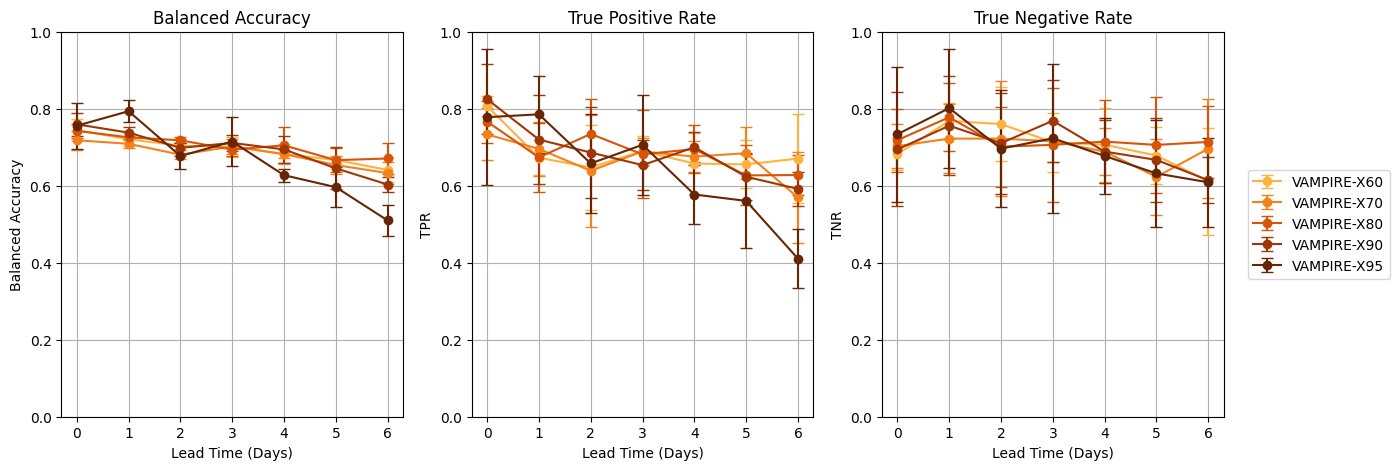

In [82]:
cmap=cb.cbmap('cb.huescale',8)
colours=[cb.cbmap('cb.pregunta',8)(5),cmap(3),cmap(4),cmap(5),cmap(6),cmap(7)]
leadtimes=[0,1,2,3,4,5,6]
labels=['X60','X70','X80','X90','X95']
fig,axs=plt.subplots(nrows=1,ncols=3,figsize=(15,5))
for model in range(0,5):
  axs[0].errorbar(leadtimes,all_bal_acc[model],yerr=all_bal_acc_err[model],capsize=4,color=colours[model+1],marker='o')
  axs[1].errorbar(leadtimes,all_tpr[model],yerr=all_tpr_err[model],capsize=4,color=colours[model+1],marker='o')
  axs[2].errorbar(leadtimes,all_tnr[model],yerr=all_tnr_err[model],capsize=4,color=colours[model+1],marker='o',label='VAMPIRE-'+labels[model])

axs[0].set_title('Balanced Accuracy')
axs[0].set_ylabel('Balanced Accuracy')
axs[0].set_xlabel('Lead Time (Days)')
axs[0].grid()
axs[0].set_ylim(0,1)

axs[1].set_title('True Positive Rate')
axs[1].set_ylabel('TPR')
axs[1].set_xlabel('Lead Time (Days)')
axs[1].grid()
axs[1].set_ylim(0,1)

axs[2].set_title('True Negative Rate')
axs[2].set_ylabel('TNR')
axs[2].set_xlabel('Lead Time (Days)')
axs[2].grid()
axs[2].set_ylim(0,1)
axs[2].legend(loc='center left',bbox_to_anchor=(1.05,0.5))

# Plotting Select Confusion Matrices

The following blocks will plot confusion matrices determined by the matrices_to_plot list.
This can be edited to the models/lead times on interest by adding/editing the individual elements. For each model and lead time you wish to plot a confusion matrix for, add a list containing two elements, the first will determine the model this should be one of the following options:
*   0 for VAMPIRE-X60
*   1 for VAMPIRE-X70
*   2 for VAMPIRE-X80
*   3 for VAMPIRE-X90
*   4 for VAMPIRE-X95

the second should be a number between 0 and 6, this is the lead time in days.

For Example:

matrices_to_plot=[[0,0],
                  [4,0],
                  [2,6]
                  ]

Would be the matrices for the VAMPIRE-X60 with a 0-day lead time, a the VAMPIRE-X95 with a 0-day lead time and the VAMPIRE-X80 for a 6-day lead time


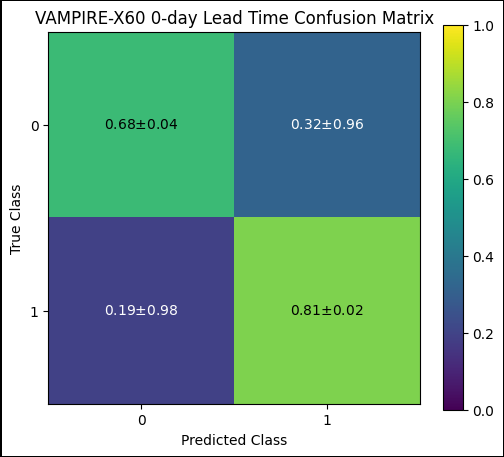

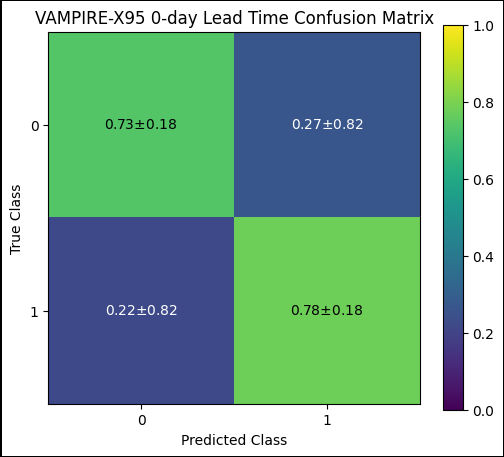

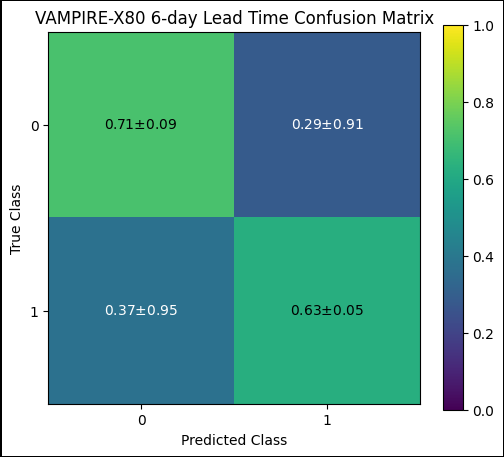

In [83]:
### Edit to select which confusion matrices you wish to plot

matrices_to_plot=[[0,0],[4,0],[2,6]]

ticks=[0,1]
labels=['0','1']
model_names=['VAMPIRE-X60','VAMPIRE-X70','VAMPIRE-X80','VAMPIRE-X90','VAMPIRE-X95']


for i in range(0,len(matrices_to_plot)):
  #print(matrices_to_plot[i])
  cm=np.array([[all_tnr[matrices_to_plot[i][0],matrices_to_plot[i][1]],1-all_tnr[matrices_to_plot[i][0],matrices_to_plot[i][1]]],
   [1-all_tpr[matrices_to_plot[i][0],matrices_to_plot[i][1]],all_tpr[matrices_to_plot[i][0],matrices_to_plot[i][1]]]])
  cm_err=np.array([[all_tnr_err[matrices_to_plot[i][0],matrices_to_plot[i][1]],1-all_tnr_err[matrices_to_plot[i][0],matrices_to_plot[i][1]]],
   [1-all_tpr_err[matrices_to_plot[i][0],matrices_to_plot[i][1]],all_tpr_err[matrices_to_plot[i][0],matrices_to_plot[i][1]]]])

  fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(6,5))

  im=ax.imshow(cm,vmin=0,vmax=1)

  ax.set_ylabel('True')
  for k in range(0,2):
      for j in range(0,2):
          if cm[k,j]<0.5:
              ax.text(j,k,'%.2f'%cm[k,j]+r'$\pm$'+'%.2f'%cm_err[k,j],color='white',horizontalalignment='center',verticalalignment='center')
          else:
              ax.text(j,k,'%.2f'%cm[k,j]+r'$\pm$'+'%.2f'%cm_err[k,j],horizontalalignment='center',verticalalignment='center')
  ax.set_xlabel('Predicted Class')
  ax.set_ylabel('True Class')
  ax.set_title(model_names[matrices_to_plot[i][0]]+' '+str(matrices_to_plot[i][1])+'-day Lead Time Confusion Matrix')
  ax.set_xticks(ticks=ticks,labels=labels)
  ax.set_yticks(ticks=ticks,labels=labels)

  fig.colorbar(im)
  fig.patch.set_linewidth(2)
  fig.patch.set_edgecolor('black')
  plt.show()
  plt.close()
  print('   ')
